<a href="https://colab.research.google.com/github/ydchen17/SeizureDetection/blob/main/Conv1D_LSTM_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc, roc_curve

In [2]:
!curl -O https://raw.githubusercontent.com/ydchen17/datasets/main/uci-epileptic-seizure-recognition.csv
df = pd.read_csv('uci-epileptic-seizure-recognition.csv', index_col=0)

from tensorflow.keras.utils import to_categorical
X = df.drop('y' ,axis = 1)
y = to_categorical(df['y']-1)
SS = StandardScaler()
SS.fit(X)
SS_X = SS.transform(X)
SS_X = np.expand_dims(SS_X, axis=-1)
SS_X_train, SS_X_test, y_train, y_test = train_test_split(SS_X, y, train_size=0.9)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7445k  100 7445k    0     0  45.7M      0 --:--:-- --:--:-- --:--:-- 45.7M


In [3]:
from keras.callbacks import Callback
import time
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.training_start_time = time.time()

    def on_epoch_end(self, batch, logs={}):
        print("total training time: "+str(time.time() - self.training_start_time)+" s")

In [4]:
import keras
from keras import Sequential
from keras.layers.core import SpatialDropout1D
from keras.layers import Embedding, Dense, LSTM, BatchNormalization, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv1D(64, kernel_size = 3, strides = 1, input_shape=(178, 1), activation="relu"))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(128, 3, activation="relu"))
model.add(Conv1D(512, 3, activation="relu"))
model.add(Conv1D(1024, 3, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(256))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(5, activation="softmax"))
adam = Adam()
model.compile(optimizer=adam,loss="categorical_crossentropy", metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 176, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 88, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 86, 128)           24704     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 84, 512)           197120    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 82, 1024)          1573888   
_________________________________________________________________
dense (Dense)                (None, 82, 256)           262400    
_________________________________________________________________
dropout (Dropout)            (None, 82, 256)           0

In [5]:
time_callback=TimeHistory()
history_5 = model.fit(SS_X_train, y_train, epochs=120, callbacks=[time_callback])

Epoch 1/120
324/324 [==============================] - 342s 1s/step - loss: 1.0410 - acc: 0.5263
total training time: 342.36071586608887 s
Epoch 2/120
324/324 [==============================] - 341s 1s/step - loss: 0.7549 - acc: 0.6513
total training time: 683.6263020038605 s
Epoch 3/120
324/324 [==============================] - 345s 1s/step - loss: 0.7012 - acc: 0.6785
total training time: 1029.017156124115 s
Epoch 4/120
324/324 [==============================] - 350s 1s/step - loss: 0.6662 - acc: 0.6790
total training time: 1379.3002679347992 s
Epoch 5/120
324/324 [==============================] - 334s 1s/step - loss: 0.6666 - acc: 0.6825
total training time: 1713.7645611763 s
Epoch 6/120
324/324 [==============================] - 342s 1s/step - loss: 0.6380 - acc: 0.6944
total training time: 2055.9824113845825 s
Epoch 7/120
324/324 [==============================] - 350s 1s/step - loss: 0.6863 - acc: 0.6786
total training time: 2406.349762439728 s
Epoch 8/120
324/324 [============

In [8]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc, roc_curve, confusion_matrix
y_pred=model.predict(SS_X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test_simplified=np.argmax(y_test, axis=1)

print(accuracy_score(y_test_simplified, y_pred),
      precision_score(y_test_simplified, y_pred, average="macro"),
      recall_score(y_test_simplified, y_pred, average="macro"),
      f1_score(y_test_simplified, y_pred, average="macro"))

0.7730434782608696 0.7749242424251626 0.7766405756540492 0.7752734704908617


In [9]:
print(confusion_matrix(y_test_simplified, y_pred))

[[217   1   0   0   0]
 [  2 159  60   3   7]
 [  1  78 147   3  10]
 [  2   2   1 190  36]
 [  0   6   8  41 176]]


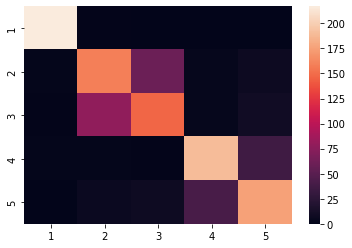

In [10]:
from seaborn import heatmap
x_labels = [1,2,3,4,5]
heatmap(confusion_matrix(y_test_simplified+1, y_pred+1),  xticklabels=x_labels, yticklabels=x_labels)

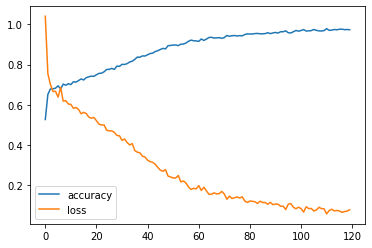

In [12]:
import matplotlib.pyplot as plt 
plt.plot(history_5.history['acc'])
plt.plot(history_5.history['loss'])
plt.legend(['accuracy', 'loss'], loc='lower left')